In [9]:
"""
Importing modules
"""

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA 
%matplotlib inline
sns.set_style('whitegrid')

In [10]:
# Multi-level keys dataframe
df = pd.read_csv('FTIR_Spectra_olive_oils.csv', header=[0,1,2])
df.head()
# Transposing to forms n_samples x n_variable matrix
df = df.T

#Extract the country names and group codes
country_names = df.index.get_level_values(2).to_list()[1::2]
grp_codes = df.index.get_level_values(1).to_list()[1::2]

# Average the two reading measured for each sample (level 0)
df = df.mean(level=0, axis=0)

# Rename the column by wavenumbers 
df.columns = df.iloc[0].round(decimals=4)
df.drop(['Sample Number:'],  inplace=True)

# Insert the group codes and country names
df.insert(0,'Group Code',grp_codes)
df.insert(0,'Country Name',country_names)


# Create a centered data: each column value is substracted the correposing column mean in the group.
df_centered_by_group = df.groupby('Country Name')[df.keys()[2:]].apply(lambda x: x- np.mean(x))
df_centered_by_group.insert(0, 'Group Code', df['Group Code'])
df_centered_by_group.insert(0, 'Country Name', df['Country Name'])
df_centered_by_group.head()

Sample Number:,Country Name,Group Code,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,...,1879.442,1881.3715,1883.301,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085
1,Greece,1,-0.000571,-0.000420,-0.000368,-0.000389,-0.000457,-0.000347,-0.000131,-0.000041,...,0.001942,0.001925,0.001955,0.002031,0.002045,0.002010,0.001994,0.001949,0.001896,0.001946
2,Greece,1,0.002636,0.002580,0.002753,0.002769,0.002667,0.002695,0.002616,0.002380,...,-0.000639,-0.000639,-0.000599,-0.000538,-0.000483,-0.000450,-0.000528,-0.000639,-0.000657,-0.000517
3,Greece,1,0.000828,0.000575,0.000565,0.000759,0.000728,0.000656,0.000616,0.000571,...,0.001650,0.001697,0.001658,0.001582,0.001574,0.001779,0.001879,0.001726,0.001685,0.001609
4,Greece,1,-0.001261,-0.001137,-0.001016,-0.001221,-0.001605,-0.001622,-0.001550,-0.001495,...,-0.002157,-0.002061,-0.002079,-0.002057,-0.002101,-0.002200,-0.002231,-0.002155,-0.002057,-0.002104
5,Greece,1,-0.000645,-0.000455,-0.000432,-0.000522,-0.000472,-0.000503,-0.000528,-0.000408,...,-0.000214,-0.000251,-0.000250,-0.000203,-0.000227,-0.000331,-0.000359,-0.000287,-0.000322,-0.000364


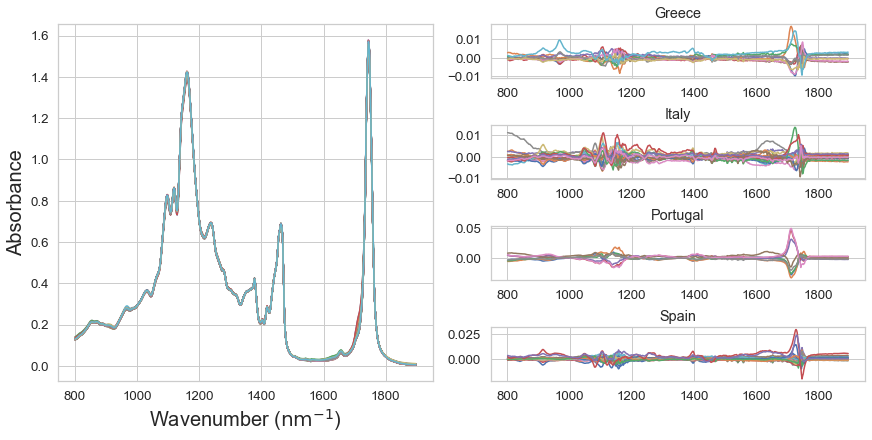

In [11]:
# Plot the spectrum for different samples
fig = plt.figure(constrained_layout=True, figsize=(12,6))
gs = GridSpec(4, 2, figure=fig)

ax = fig.add_subplot(gs[:,0])
[ax.plot(df.keys().values[3:], df.iloc[i,3:]) for i in range(len(df.index))]
ax.set_xlabel('Wavenumber ($\mathrm{nm}^{-1}$)', fontsize=20)
ax.set_ylabel('Absorbance', fontsize = 20)

i = 0
for key, group in df_centered_by_group.groupby('Country Name'):
     ax = fig.add_subplot(gs[i,1])
     ax.set_title(key)
     [ax.plot(group.keys().values[3:], group.iloc[i,3:]) for i in range(len(group.index))]
     i = i+1

The left figure shows the spectrum for all the samples (inclusing all classes), while the right figure depicts the centered data (data subtracted by mean if columns in a group) for all the four varieties of olive oils. 

In [13]:
# Input features, and response variable
x = df[df.keys()[3:]].values
Y = df['Country Name'].to_numpy()


First, it is instructive to check whether PCA can help disntinguishing different classes. Below, the dats is visualized both using 2-component and 3-component PCA vectors. 

Variation explanined by 3 PCA comps[0.63794447 0.20463788 0.06145825]


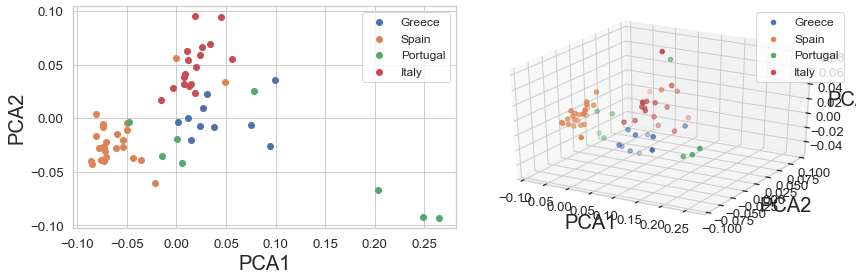

In [14]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(x)
print('Variation explanined by 3 PCA comps{:}'.format(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
country_names = ['Greece', 'Spain', 'Portugal', 'Italy']
for country in country_names:
    ax1.scatter(X_pca[Y == country, 0], X_pca[Y == country,1], label=country)
    ax2.scatter(X_pca[Y == country, 0], X_pca[Y == country,1], X_pca[Y == country,2], label=country)
    
ax1.set_xlabel('PCA1', fontsize=20)
ax1.set_ylabel('PCA2', fontsize=20)
ax1.legend(fontsize=12)


ax2.set_xlabel('PCA1', fontsize=20)
ax2.set_ylabel('PCA2', fontsize=20)
ax2.set_zlabel('PCA3', fontsize=20)
ax2.legend(fontsize=12)
fig.tight_layout()


The first two components explains approx. 80% of the variance, and does show some class disctiction; variety from Spain (orange) and Italy (red) do form clear clusters while the variety from Greece also clusters but to relatively lesser extent. However, the variety from Portugal is quite widepsread and does not show any clear class resemblence. The addition of third PCA vector does not help much in differentiating the Portugal class. 

Variation explanined by 3 LDA comps[0.5333829  0.33125572 0.13536139]


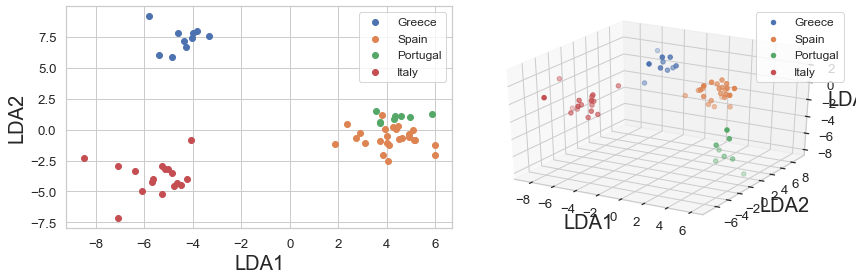

In [15]:
# Three different Models: LDA, KNN, and NCA
lda = LDA(n_components=3)
X_lda = lda.fit_transform(x,Y)
print('Variation explanined by 3 LDA comps{:}'.format(lda.explained_variance_ratio_))

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
country_names = ['Greece', 'Spain', 'Portugal', 'Italy']
for country in country_names:
    ax1.scatter(X_lda[Y == country, 0], X_lda[Y == country,1], label=country)
    ax2.scatter(X_lda[Y == country, 0], X_lda[Y == country,1], X_lda[Y == country,2], label=country)
    
ax1.set_xlabel('LDA1', fontsize=20)
ax1.set_ylabel('LDA2', fontsize=20)
ax1.legend(fontsize=12)
#ax1.grid()

ax2.set_xlabel('LDA1', fontsize=20)
ax2.set_ylabel('LDA2', fontsize=20)
ax2.set_zlabel('LDA3', fontsize=20)
ax2.legend(fontsize=12)
fig.tight_layout()

# All results in one dataframe
#results = pd.DataFrame(data={'LDA': lda_comp.ravel(),'Variety': Y}) 

LDA does help differentiating the class! The first two LDA-space clearly differentiates the Greece and Italy varieties, however, the Spain and Portugal varieties are not separates properly. The addition of third component does help in separating all the class, as the third component add 13.5% to the explained variance ratio.  

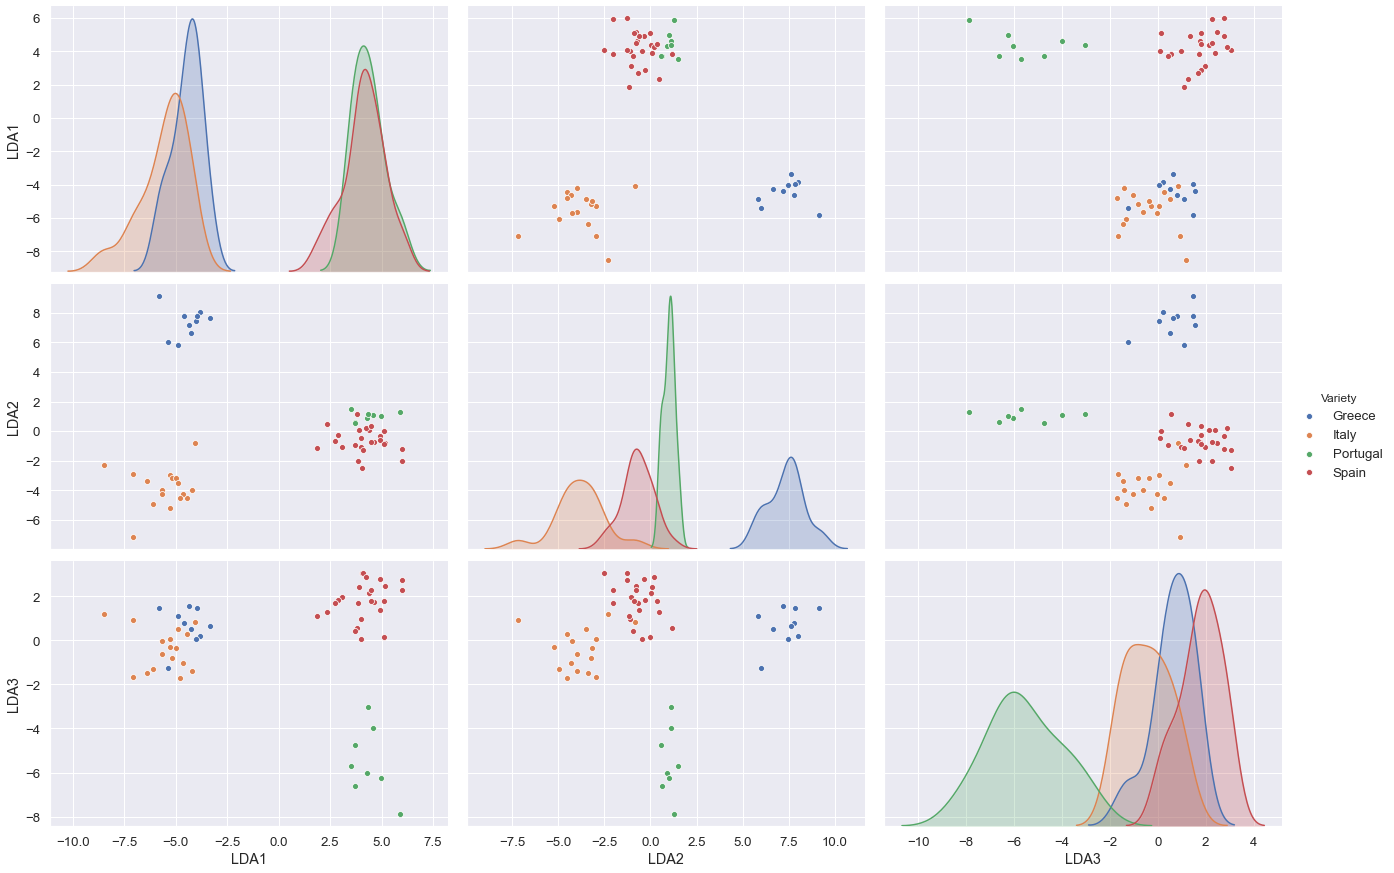

In [16]:
results = pd.DataFrame({"Variety":Y, "LDA1":X_lda[:,0], "LDA2":X_lda[:,1], "LDA3":X_lda[:,2]})

sns.set(font_scale=1.2)
sns.pairplot(results, hue="Variety", height=4, aspect=1.5)

A key assumption in the LDA method is that the data among each class is normally distributed. As it's clear from the above plots that for all the LDA vectors, the data closely resembles Gaussian distribution. Moreover, the above co-corrleation plots between different LDAs demonstrate the the classes are well separeted by LDA. 